In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
import glob

from matplotlib.dates import DateFormatter, MonthLocator
import matplotlib.dates as mdates
import matplotlib.colors as colors
import gsw
import json
import numpy as np
from numpy.polynomial.polynomial import polyval

from scipy import signal

import matplotlib as mpl

import xarray as xr

# 1. Define functions


$ [O_{2}] = \frac{(\phi_{0}/\phi-1)}{K_{sv}}S_{corr} $


In [14]:
def O2_SVU(calphase, temp, psal, pres, lon, lat, SVU_coef, S0=0):
    #Written by Roo Nicholson, WHOI https://github.com/boom-lab/gohsnap-py
    
    """Calculate O2 concentration in umol/kg from calibrated phase and SVU coefficients

    Args:
        calphase (float): calibrated phase
        temp (float): _description_
        psal (float): _description_
        pres (float): _description_
        lon (float): _description_
        lat (float): _description_
        SVU_coef (list): Ascending orer: (SVUCoef0 ... SVUCoef6)
        S0 (float, optional): internally set salinity value. Defaults to 0.

    Returns:
        (O2,O2eq) (float,float): oxygen concentration (umol/kg) and equilibrium solubility 
    """    

    K0 = 273.15
    o2coef = {
        'b': (-6.24097E-3, -6.93498E-3, -6.90358E-3, -4.29155E-3),
        'c0': (-3.11680E-7)
    }
    # physical variables
    SA = gsw.SA_from_SP(psal,pres,lon,lat)
    CT = gsw.CT_from_t(SA,temp,pres)
    O2eq = gsw.O2sol(SA,CT,pres,lon,lat)
    rho0 = 1000 + gsw.sigma0(SA,CT)

    PC = SVU_coef
    Ksv = PC[0] + PC[1]*temp + PC[2]*temp**2
    P0 = PC[3] + PC[4]*temp
    PC = PC[5] + PC[6] * calphase
    optode_uM = ((P0 / PC) - 1) / Ksv

    # scaled temperature
    temps = np.log((K0 + 25 - temp) / (K0+temp))

    # salinity corr
    Scorr = np.exp((psal-S0) *polyval(temps,o2coef['b']) + o2coef['c0'] * (psal**2-S0**2))
    O2 = 1000 * Scorr  * optode_uM / rho0
    return(O2,O2eq)


# 2. Import data

In [15]:
df_all = pd.read_csv('Files/example_metadata.csv', header = 0)
df_all

,serial_number,station,latitude,longitude,nominal_depth,deployment_caldip_id,deployment_calcast_id,recovery_calcast_id,microcat_filename,deployment_cruise_filename,recovery_cruise_filename,optode_caldip_filename,optode_deployment_filename,optode_cal_coeffs_filename
0,204368.0,M1,59.903,-41.110,50.0,4.0,12.0,17.0,M1_OS_OSNAP-WHOI_M1_202008_MCTD_50m.nc,downcasts_AR46.csv,downcasts_AR69_01.csv,RBRCONCERTO_204368_20200816_0002.txt,m1-01_sn204368_data.txt,aacal_204368.json
1,204381.0,M3,59.819,-40.275,1000.0,4.0,10.0,10.0,M3_OS_OSNAP-WHOI_M3_202008_MCTD_1000m.nc,downcasts_AR46.csv,downcasts_AR69_01.csv,RBRCONCERTO_204381_20200815_2354.txt,m3-01_sn204381_data.txt,aacal_204381.json
2,204380.0,M3,59.819,-40.275,2557.0,4.0,10.0,10.0,M3_OS_OSNAP-WHOI_M3_202008_MCTD_2517m.nc,downcasts_AR46.csv,downcasts_AR69_01.csv,RBRCONCERTO_204380_20200816_0001.txt,m3-08_sn204380_data.txt,aacal_204380.json
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_all = pd.read_csv('Files/example_metadata.csv', header = 0)
serial_num = 204380
df_sn = df_all[df_all.serial_number == serial_num]

deploy_station_caldip = df_sn.deployment_caldip_id.values[0]
deploy_station_calcast = df_sn.deployment_calcast_id.values[0]
recov_station_calcast = df_sn.recovery_calcast_id.values[0]


In [17]:
pd.read_csv(os.path.join('Files',str(serial_num),df_sn.optode_deployment_filename.values[0])).set_index('timestamp')

,Unnamed: 0,temperature,dissolved_o2_concentration,calibrated_phase
timestamp,,,,
2020-08-21 00:00:00,0,14.876997,302.997947,29.327831
2020-08-21 00:15:00,1,14.928001,302.803993,29.311867
2020-08-21 00:30:00,2,14.984000,302.493930,29.298992
2020-08-21 00:45:00,3,15.041995,302.080989,29.287834
2020-08-21 01:00:00,4,15.101999,301.663995,29.275990
...,...,...,...,...
2022-07-03 17:15:00,65445,12.656999,327.458978,29.456921
2022-07-03 17:30:00,65446,14.984000,312.739968,28.910866
2022-07-03 17:45:00,65447,16.545999,302.093983,28.608913


In [18]:

# Import deployment cruise CTD-DO

df = pd.read_csv(os.path.join('Files',df_sn.deployment_cruise_filename.values[0]))
df.CastTimeUTC = pd.to_datetime(df.CastTimeUTC)
df = df.set_index(pd.to_datetime(df.CastTimeUTC))
df = df.drop_duplicates(subset=['CastTimeUTC'])
caldip_deploy_date = df.pt.where(df.Station == deploy_station_caldip).dropna().index[0]

T_caldip_deploy = df.pt.where(df.Station == deploy_station_caldip).dropna().resample('10s').nearest()
sigma0_caldip_deploy = df.sigma0.where(df.Station == deploy_station_caldip).dropna().resample('10s').nearest()
S_caldip_deploy = df.sal1.where(df.Station == deploy_station_caldip).dropna().resample('10s').nearest()
p_caldip_ctd_deploy = df.prs.where(df.Station == deploy_station_caldip).dropna().resample('10s').nearest()
ctd_caldip_oxy_deploy = df.AA_DOcorr_umolkg.where(df.Station == deploy_station_caldip).dropna().resample('10s').nearest()
lat_caldip_deploy = df.lat.iloc[0]

T_calcast_deploy = df.pt.where(df.Station == deploy_station_calcast).dropna().resample('10s').nearest()
sigma0_calcast_deploy = df.sigma0.where(df.Station == deploy_station_calcast).dropna().resample('10s').nearest()
S_calcast_deploy = df.sal1.where(df.Station == deploy_station_calcast).dropna().resample('10s').nearest()
p_calcast_ctd_deploy = df.prs.where(df.Station == deploy_station_calcast).dropna().resample('10s').nearest()
ctd_calcast_oxy_deploy = df.AA_DOcorr_umolkg.where(df.Station == deploy_station_calcast).dropna().resample('10s').nearest()
lat_calcast_deploy = df.lat.iloc[0]
calcast_deploy_date = df.pt.where(df.Station == deploy_station_calcast).dropna().index[0]


#Import recovery cruise CTD-DO

df = pd.read_csv(os.path.join('Files',df_sn.recovery_cruise_filename.values[0]))
df.CastTimeUTC = pd.to_datetime(df.CastTimeUTC)
df = df.set_index(pd.to_datetime(df.CastTimeUTC))
df = df.drop_duplicates(subset=['CastTimeUTC'])


calcast_recov_date = df.index[0]
T_calcast_recov = df.pt.where(df.Station == recov_station_calcast).dropna().resample('10s').nearest()
S_calcast_recov = df.sal1.where(df.Station == recov_station_calcast).dropna().resample('10s').nearest()
sigma0_calcast_recov = df.sigma0.where(df.Station == recov_station_calcast).dropna().resample('10s').nearest()
p_calcast_ctd_recov = df.prs.where(df.Station == recov_station_calcast).dropna().resample('10s').nearest()
ctd_calcast_oxy_recov = df.DOcorr_umolkg.where(df.Station == recov_station_calcast).dropna().resample('10s').nearest()
lat_calcast_recov = df.lat.iloc[0]

# import cal-dip optode-DO profile

df = pd.read_csv(os.path.join('Files',str(serial_num),df_sn.optode_caldip_filename.values[0])).set_index('Time')
df.index = pd.to_datetime(df.index) 

df["serial_number"] = serial_num
df = df.rename(columns={"Var1_1": "TEMP"})
df = df.rename(columns={"Var1_2": "dissolved_o2_concentration"})
df = df.rename(columns={"Var1_3": "calibrated_phase"})
df["LONGITUDE"] = df_sn.latitude.values[0]
df["LATITUDE"] = df_sn.longitude.values[0]
df["PSAL"] = df.align(S_caldip_deploy, axis = 0)[1].dropna()



df["PRES"] = df.align(p_caldip_ctd_deploy, axis = 0)[1].dropna()
df["SA"] = gsw.SA_from_SP(df.PSAL,df.PRES,df.LONGITUDE,df.LATITUDE)
df["CT"] = gsw.CT_from_t(df.SA,df.TEMP,df.PRES)
df["sigma0"] = gsw.sigma0(df.SA,df.CT)
cal =  json.load(open(os.path.join('Files',str(serial_num),df_sn.optode_cal_coeffs_filename.values[0])))
if cal is None:
    df["DOXY"] = np.nan
    df["O2eq"] = np.nan
else:
    df["DOXY"],df["O2eq"] = O2_SVU(df["calibrated_phase"], df["TEMP"], df["PSAL"], df["PRES"], df["LONGITUDE"], df["LATITUDE"], cal['SVUFoilCoef'], S0=cal["Salinity"])
# return df

deployment_caldip_optode_oxy = df.DOXY #umol/kg
deployment_caldip_optode_oxy = deployment_caldip_optode_oxy[p_caldip_ctd_deploy.index]#*((1000+sigma0_caldip_deploy)/1000) #convert umol/kg to umol/l

# import microcat

mc = xr.open_dataset(os.path.join('Files',str(serial_num), df_sn.microcat_filename.values[0])).resample(TIME = '15min').nearest()
asal = gsw.SA_from_SP(mc.PSAL, mc.PRES, mc.LONGITUDE.values, mc.LATITUDE.values)
mc = mc.assign(PTEMP = gsw.pt0_from_t(asal,mc.TEMP,mc.PRES))



# import optode-DO time series and align timestamps with microcat data

df = pd.read_csv(os.path.join('Files',str(serial_num),df_sn.optode_deployment_filename.values[0])).set_index('timestamp')
df.index = pd.to_datetime(df.index) 

df["serial_number"] = serial_num
df = df.rename(columns={"temperature": "TEMP"})
# df = df.rename(columns={"Dissolved O2 concentration": "dissolved_o2_concentration"})
# df = df.rename(columns={"Calibrated phase": "calibrated_phase"})
df["LONGITUDE"] = df_sn.latitude.values[0]
df["LATITUDE"] = df_sn.longitude.values[0]
df["PSAL"] = df.align(mc.PSAL.to_pandas(), axis = 0)[1].dropna()


df["PRES"] = df.align(mc.PRES.to_pandas(), axis = 0)[1].dropna()
df["SA"] = gsw.SA_from_SP(df.PSAL,df.PRES,df.LONGITUDE,df.LATITUDE)
df["CT"] = gsw.CT_from_t(df.SA,df.TEMP,df.PRES)
df["sigma0"] = gsw.sigma0(df.SA,df.CT)
cal =  json.load(open(os.path.join('Files',str(serial_num),df_sn.optode_cal_coeffs_filename.values[0])))
if cal is None:
    df["DOXY"] = np.nan
    df["O2eq"] = np.nan
else:
    df["DOXY"],df["O2eq"] = O2_SVU(df["calibrated_phase"], df["TEMP"], df["PSAL"], df["PRES"], df["LONGITUDE"], df["LATITUDE"], cal['SVUFoilCoef'], S0=cal["Salinity"])
# return df


optode_oxy = df.DOXY #umol/kg

mc_tmp = pd.DataFrame(data = {'TEMP': mc.TEMP.values.flatten(), 'PTEMP': mc.PTEMP.values.flatten(), 'PSAL': mc.PSAL.values.flatten(),'PRES': mc.PRES.values.flatten()}, 
                          index= pd.to_datetime(mc.TIME.values)).join(optode_oxy)






# 3. Determine optimal pressure compensation factor $p_{fac}$ in $P_{corr}$

$P_{corr} = 1 + \frac{p_{fac}\ p}{1000}$

In [19]:
cf=np.arange(0.01,0.05,0.001)

oxy_rbr_av_pc = []
S_s = 0.0

# downcast
for i in cf: 
    P_corr = (np.abs(p_caldip_ctd_deploy.values)/1000.0)*i + 1.0;
    oxy_rbr_av_pc.append(deployment_caldip_optode_oxy.values * P_corr)

diff_std = []
for i in range(len(cf)):
    diff_std.append(np.std(ctd_caldip_oxy_deploy.values[50:340] - oxy_rbr_av_pc[i][50:340]))


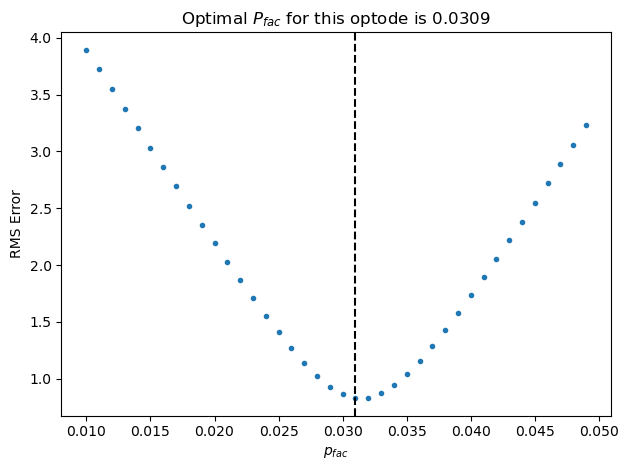

In [20]:

plt.plot(cf,diff_std,'.')
plt.xlabel('$p_{fac}$')
plt.ylabel('RMS Error')
plt.title('Optimal $P_{fac}$ for this optode is ' + str(cf[np.argmin(diff_std)])[:6])
plt.axvline(cf[np.argmin(diff_std)],color ='k', linestyle = 'dashed')

plt.tight_layout()


# 4. Apply $P_{corr}$ with optimal factor

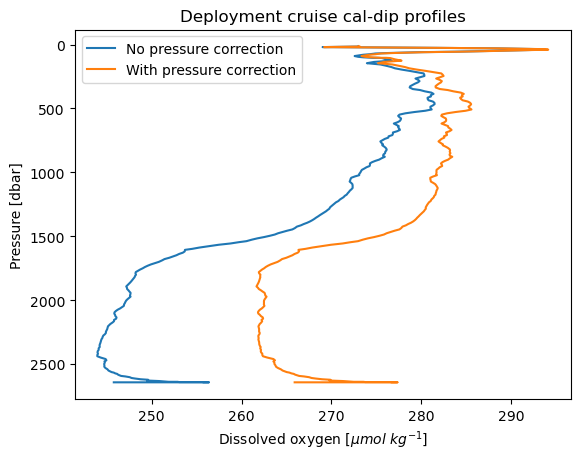

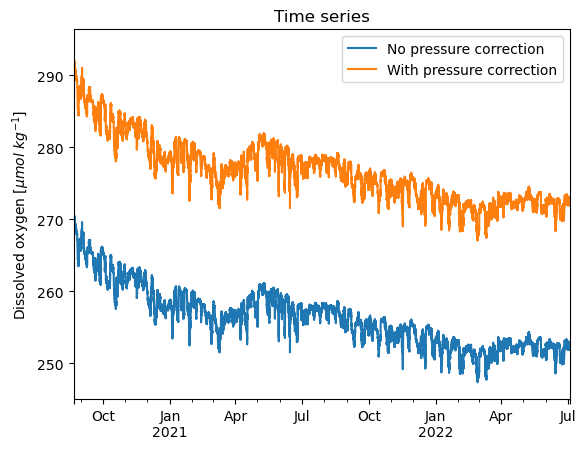

In [21]:
P_corr = (np.abs(p_caldip_ctd_deploy.values)/1000.0)*cf[np.argmin(diff_std)] + 1.0;

deployment_caldip_optode_oxy_corr = deployment_caldip_optode_oxy * P_corr

P_corr = (np.abs(mc_tmp.PRES)/1000.0)*cf[np.argmin(diff_std)] + 1.0;

optode_oxy_corr = mc_tmp.DOXY * P_corr
optode_oxy_corr

plt.plot(deployment_caldip_optode_oxy, p_caldip_ctd_deploy, label = 'No pressure correction')
plt.plot(deployment_caldip_optode_oxy_corr, p_caldip_ctd_deploy, label = 'With pressure correction')

plt.gca().invert_yaxis()
plt.legend()
plt.title('Deployment cruise cal-dip profiles')
plt.ylabel('Pressure [dbar]')
plt.xlabel('Dissolved oxygen $[\mu mol \ kg^{-1}]$')
plt.figure()

mc_tmp.DOXY.plot(label = 'No pressure correction')
optode_oxy_corr.plot(label = 'With pressure correction')
plt.ylabel('Dissolved oxygen $[\mu mol \ kg^{-1}]$')
plt.title('Time series')
plt.legend()

# 5. Check for reversible drift

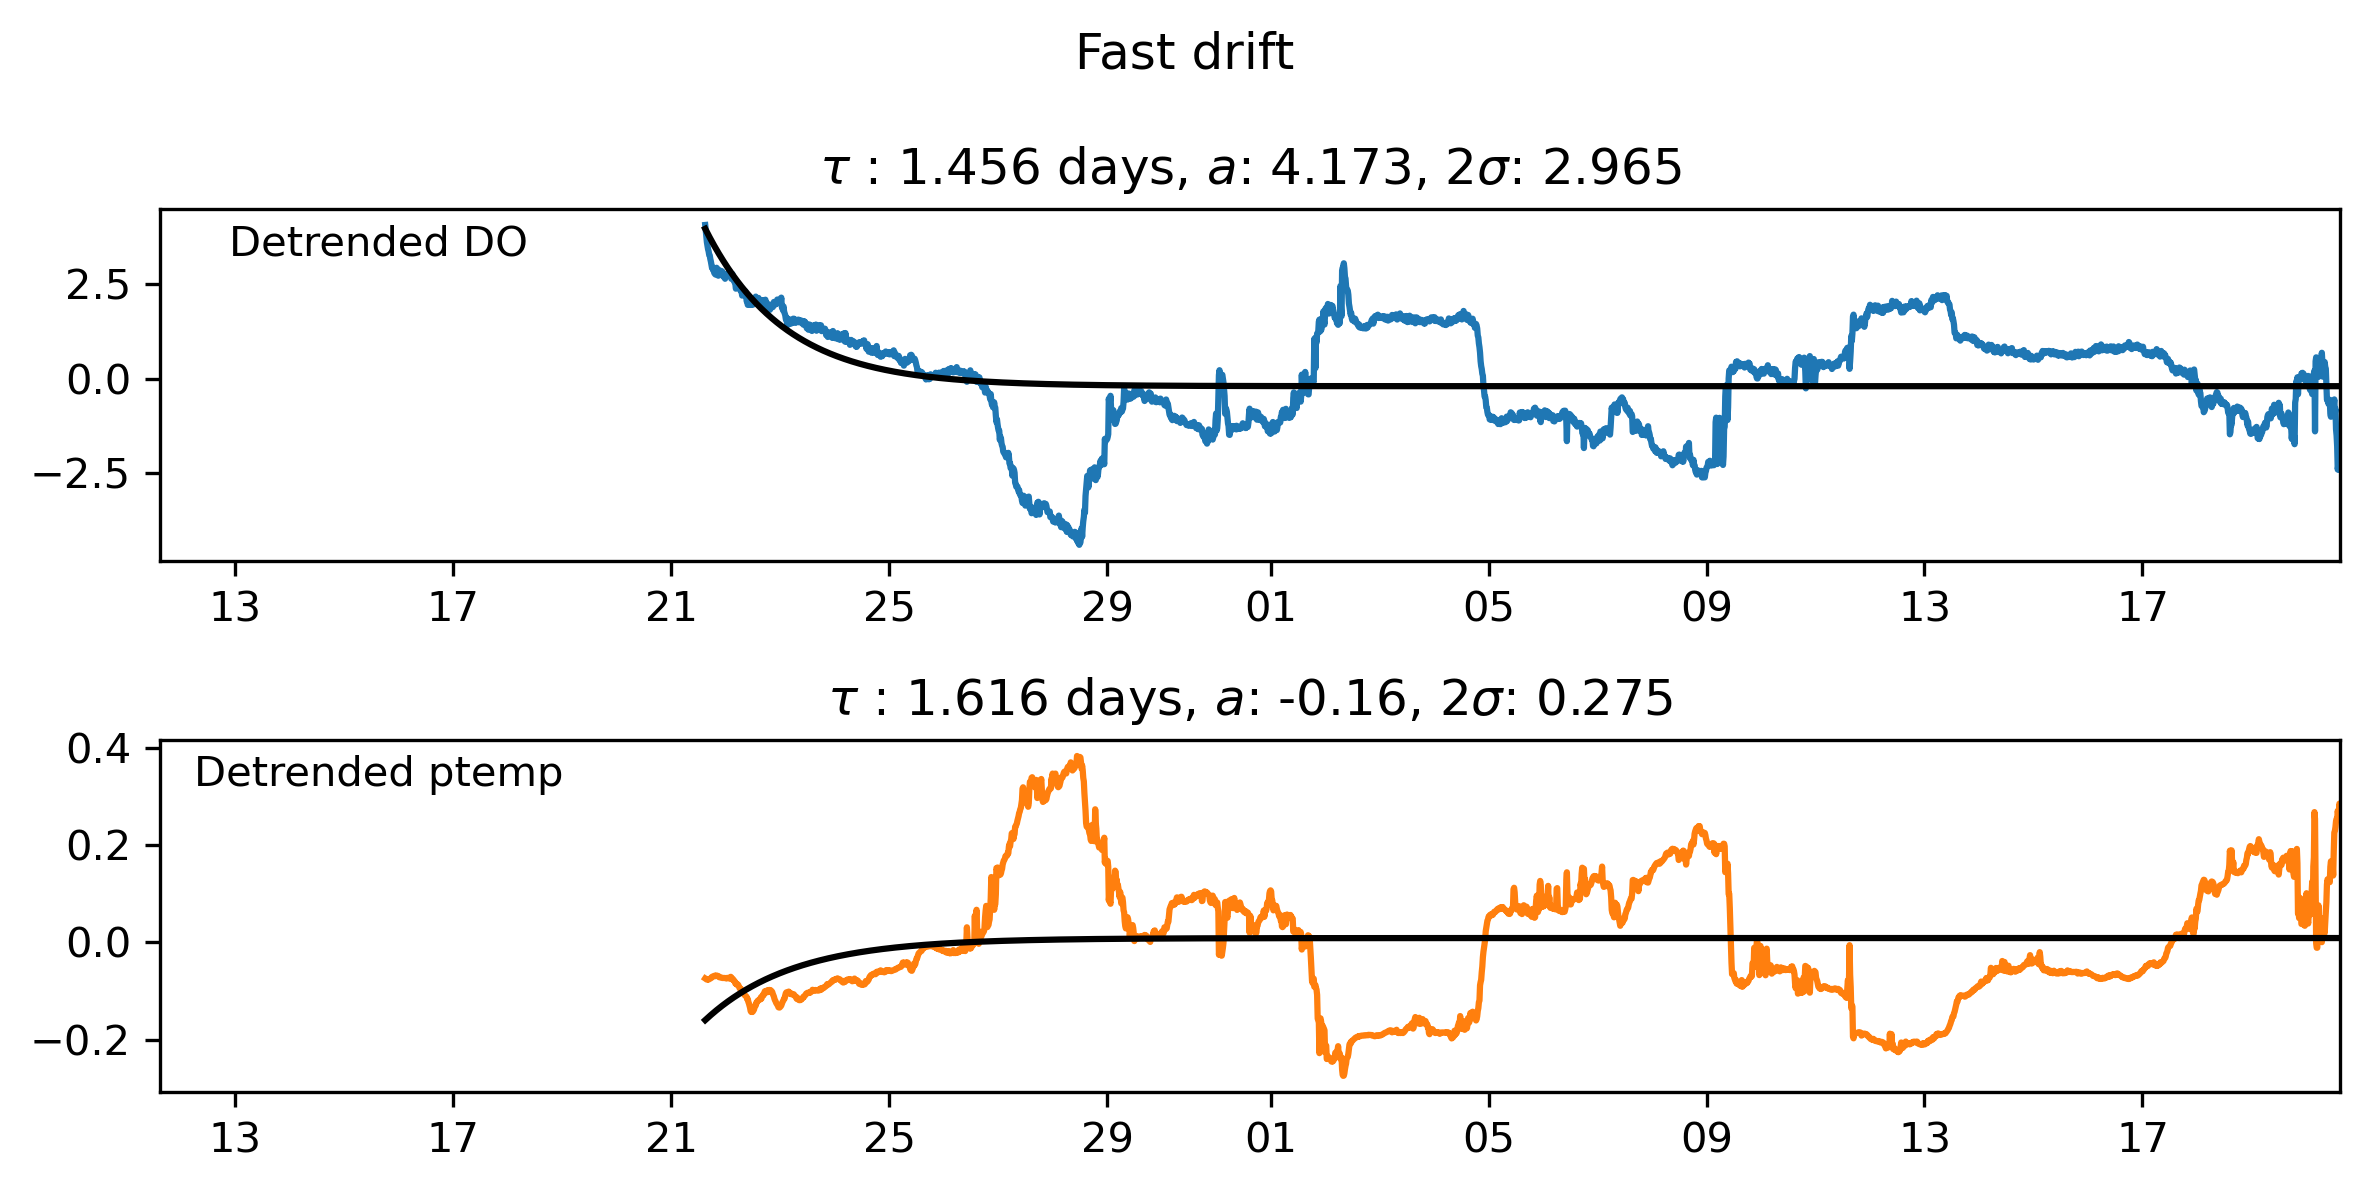

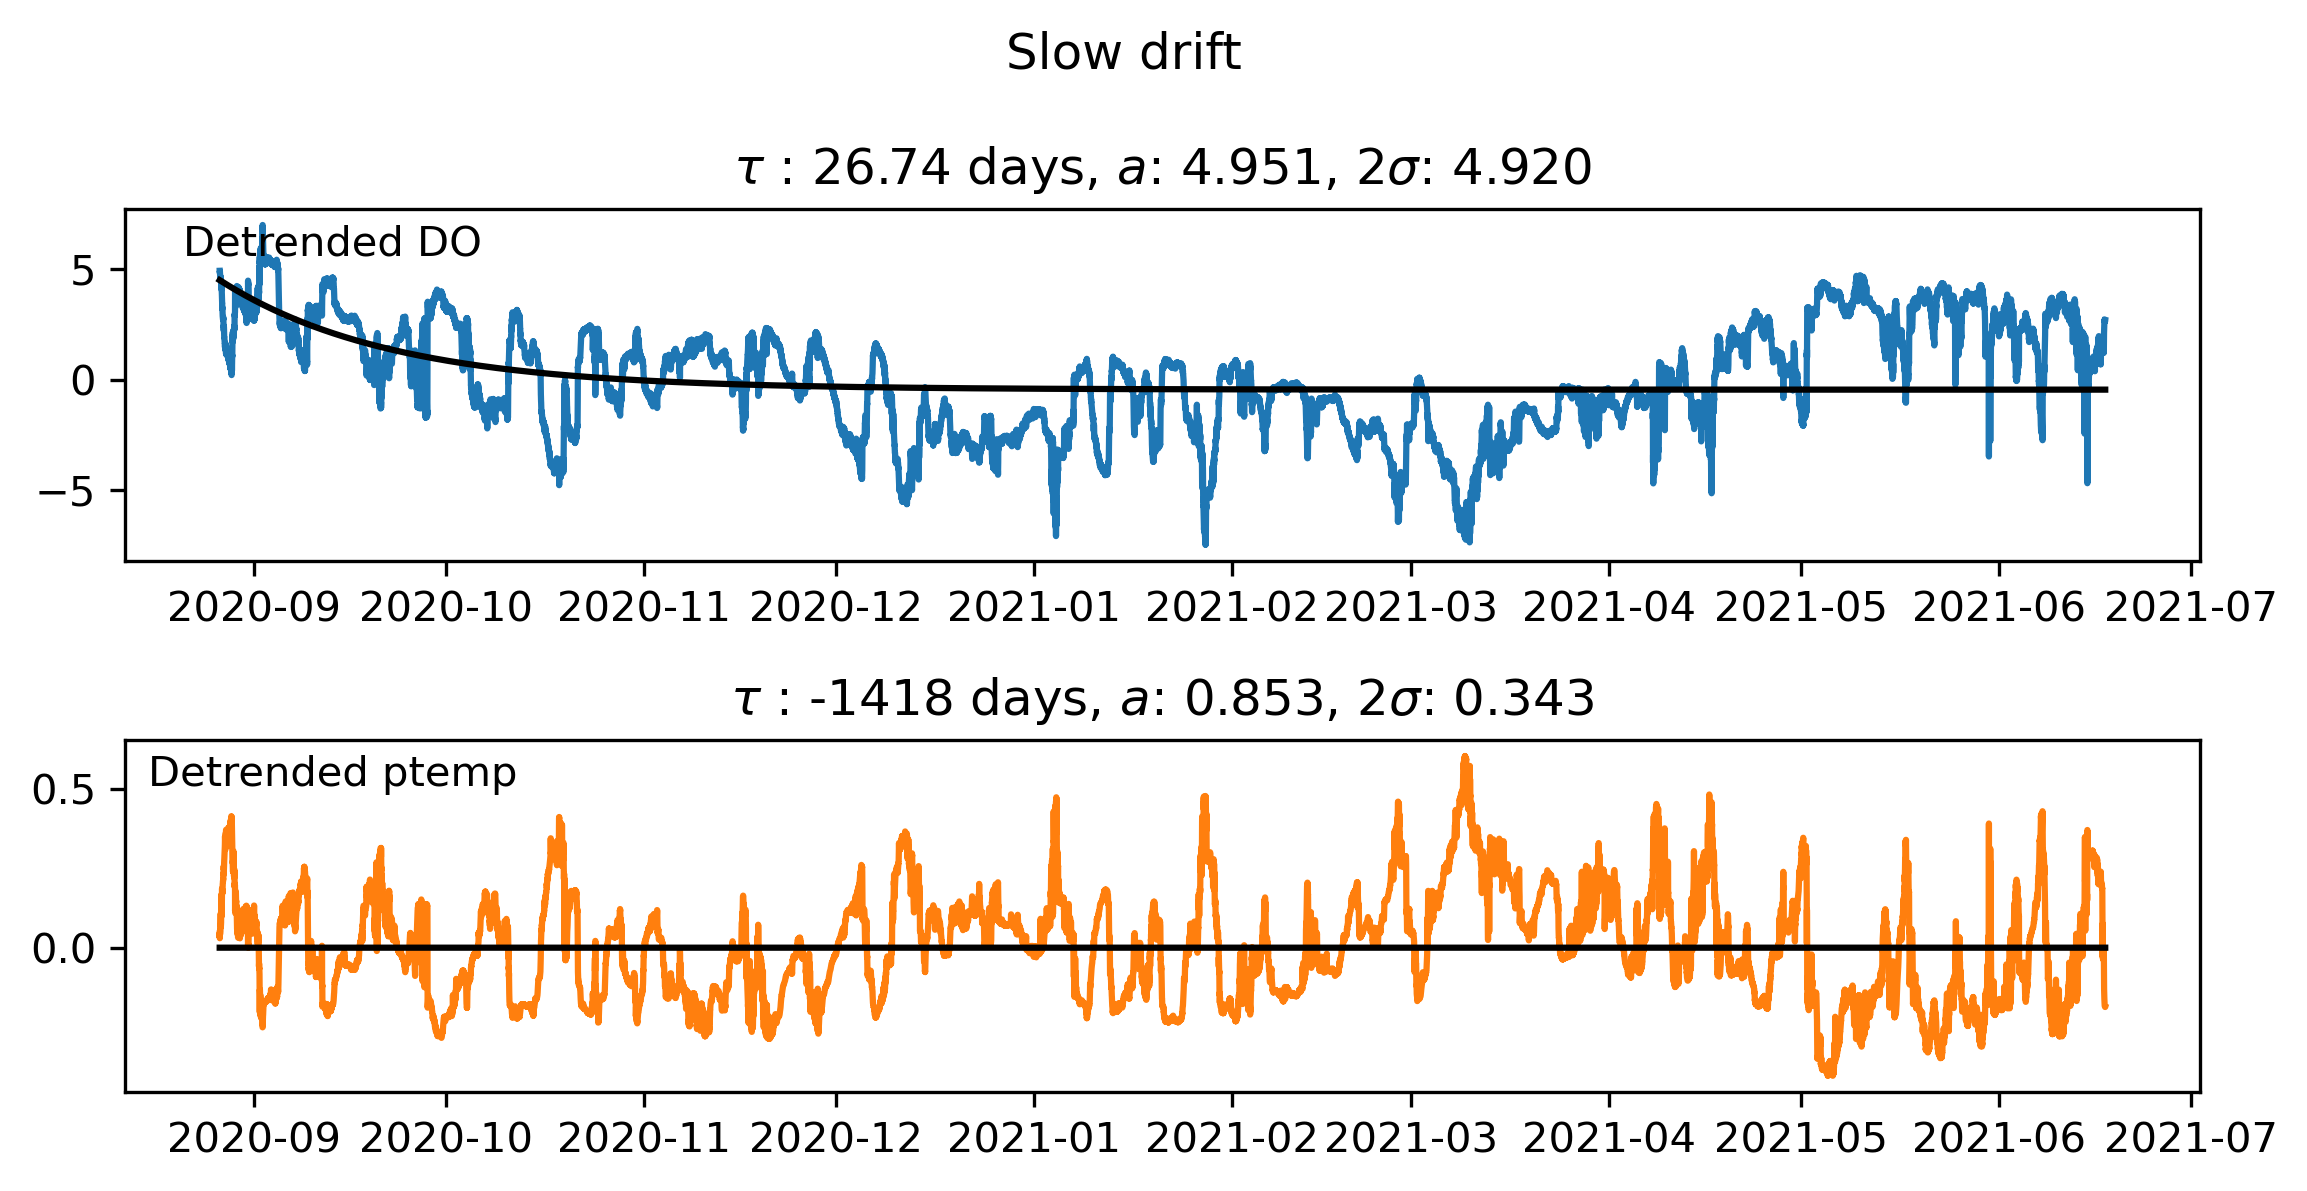

In [22]:


serial_num = int(serial_num)


time_fit = ['30d', '300d']
b_drift_guess=np.array([0.005, 0.00005])
name = ['Fast','Slow']


minutes = (optode_oxy_corr.index[1] - optode_oxy_corr.index[0]).total_seconds()/60

for i in np.array([0,1]):
    
    tf = time_fit[i]
    bdg = b_drift_guess[i] 

    plt.figure(figsize=(8, 4), dpi=300)############################################################################################

    ####### Oxygen #########
    ax1 = plt.subplot(211)

    # Subset of first 30 (fast) or 300 (slow) days of optode-DO time series
    if i == 0: #timescale for fast reversible drift
        
        tmp = signal.detrend(optode_oxy_corr.interpolate()[optode_oxy_corr.index[0]:optode_oxy_corr.index[0]+pd.Timedelta(tf)].values)
        
        plt.plot(optode_oxy_corr[optode_oxy_corr.index[0]:optode_oxy_corr.index[0]+pd.Timedelta(tf)].index,tmp)

    else: #timescale for slow reversible drift
         
        tmp = signal.detrend(optode_oxy_corr.interpolate()[optode_oxy_corr.index[0]+ pd.Timedelta('5d'):optode_oxy_corr.index[0]+pd.Timedelta(tf)].values)
        plt.plot(optode_oxy_corr[optode_oxy_corr.index[0]+ pd.Timedelta('5d'):optode_oxy_corr.index[0]+pd.Timedelta(tf)].index,tmp)
    
    
    
    # Fit exponential function to the optode-DO subset y = a*e^(-bx) + c
    a_drift_guess = (tmp[:8].mean() - tmp[-8:].mean())

    c_drift_guess = tmp[-8:].mean()
    
    popt, pcov = curve_fit(lambda x, a_drift, b_drift, c_drift: 
                        a_drift * np.exp(-b_drift * x) + c_drift,np.arange(len(tmp)), 
                                        tmp, p0 = [a_drift_guess, bdg, c_drift_guess])
    a_drift= popt[0] 
    b_drift = popt[1]
    c_drift = popt[2]
    #print(a_drift)
    #print(b_drift)
    #print(1/b_drift*minutes/60/24)
    #print(c_drift)
    y_fitted_drift = a_drift * np.exp(-b_drift * np.arange(len(tmp))) 
    perr = np.sqrt(np.diag(pcov))
    plt.title(r'$\tau$ : ' + str(1/b_drift*minutes/60/24)[:5]  + ' days, $a$: ' + str(a_drift)[:5] + ', 2$\sigma$: ' + str(2*np.nanstd(tmp))[:5])

    
    ax1.text(0.1, 0.9, 'Detrended DO', horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)
    if i == 0:
        plt.plot(optode_oxy_corr[optode_oxy_corr.index[0]:optode_oxy_corr.index[0]+pd.Timedelta(tf)].index, y_fitted_drift+ c_drift, color = 'k')
        plt.xlim([optode_oxy_corr.index[0]- pd.Timedelta('10d'),optode_oxy_corr.index[0]+pd.Timedelta(tf)])
        myFmt = mdates.DateFormatter('%d')
        ax1.xaxis.set_major_formatter(myFmt)
    else:
        plt.plot(optode_oxy_corr[optode_oxy_corr.index[0] + pd.Timedelta('5d'):optode_oxy_corr.index[0]+pd.Timedelta(tf)].index, y_fitted_drift+ c_drift, color = 'k')


    ax2 = plt.subplot(212)

    ####### Repeat for temperature #########

    if i == 0:
         tmp = signal.detrend(mc_tmp.PTEMP.interpolate()[optode_oxy_corr.index[0]:optode_oxy_corr.index[0]+pd.Timedelta(tf)].values)
         plt.plot(optode_oxy_corr[optode_oxy_corr.index[0]:optode_oxy_corr.index[0]+pd.Timedelta(tf)].index,tmp, color = 'tab:orange')
    else:
         tmp = signal.detrend(mc_tmp.PTEMP.interpolate()[optode_oxy_corr.index[0] + pd.Timedelta('5d'):optode_oxy_corr.index[0]+pd.Timedelta(tf)].values)
    
         plt.plot(optode_oxy_corr[optode_oxy_corr.index[0] + pd.Timedelta('5d'):optode_oxy_corr.index[0]+pd.Timedelta(tf)].index,tmp, color = 'tab:orange')
    plt.text(0.1, 0.9, 'Detrended ptemp', horizontalalignment='center',verticalalignment='center', transform=ax2.transAxes)
    # fit slow drift
    a_drift_guess = (tmp[:8].mean() - tmp[-8:].mean())

    c_drift_guess = tmp[-8:].mean()
    
    popt, pcov = curve_fit(lambda x, a_drift, b_drift, c_drift: 
                        a_drift * np.exp(-b_drift * x) + c_drift,np.arange(len(tmp)), 
                                        tmp, p0 = [a_drift_guess, bdg, c_drift_guess])
    a_drift= popt[0] 
    b_drift = popt[1]
    c_drift = popt[2]
    #print(a_drift)
    #print(b_drift)
    #print(1/b_drift*minutes/60/24)
    #print(c_drift)
    y_fitted_drift = a_drift * np.exp(-b_drift * np.arange(len(tmp))) 
    perr = np.sqrt(np.diag(pcov))
    plt.title(r'$\tau$ : ' + str(1/b_drift*minutes/60/24)[:5]  + ' days, $a$: ' + str(a_drift)[:5] + ', 2$\sigma$: ' + str(2*np.nanstd(tmp))[:5])

    if i == 0:
        plt.plot(optode_oxy_corr[optode_oxy_corr.index[0]:optode_oxy_corr.index[0]+pd.Timedelta(tf)].index, y_fitted_drift+ c_drift, color = 'k')
        plt.xlim([optode_oxy_corr.index[0]- pd.Timedelta('10d'),optode_oxy_corr.index[0]+pd.Timedelta(tf)])
        myFmt = mdates.DateFormatter('%d')
        ax2.xaxis.set_major_formatter(myFmt)
    else:
        plt.plot(optode_oxy_corr[optode_oxy_corr.index[0] + pd.Timedelta('5d'):optode_oxy_corr.index[0]+pd.Timedelta(tf)].index, y_fitted_drift+ c_drift, color = 'k')



    plt.suptitle(name[i] + ' drift')

    plt.tight_layout()



# 6. Remove reversible drift

Step 5 analysis suggests slow reversible drift. Remove

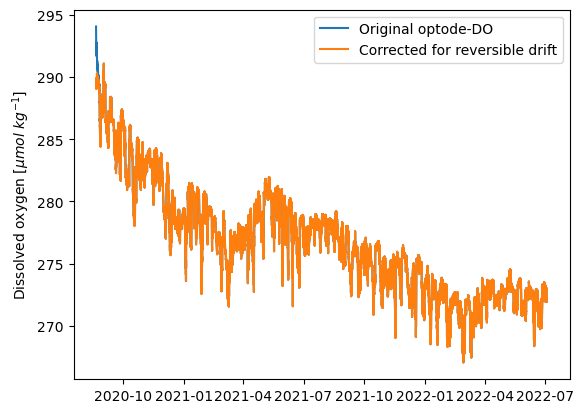

In [23]:

tmp = signal.detrend(optode_oxy_corr.interpolate()[optode_oxy_corr.index[0]:optode_oxy_corr.index[0]+pd.Timedelta('30d')].values)


 


# fit slow drift
a_drift_guess = (tmp[:8].mean() - tmp[-8:].mean())

c_drift_guess = tmp[-8:].mean()

popt, pcov = curve_fit(lambda x, a_drift, b_drift, c_drift: 
                    a_drift * np.exp(-b_drift * x) + c_drift,np.arange(len(tmp)), 
                                    tmp, p0 = [a_drift_guess, 0.005, c_drift_guess])
a_drift= popt[0] 
b_drift = popt[1]
c_drift = popt[2]
#print(a_drift)
#print(b_drift)
#print(1/b_drift*minutes/60/24)
#print(c_drift)
y_fitted_drift = a_drift * np.exp(-b_drift * np.arange(len(tmp))) 

plt.plot(optode_oxy_corr.index, optode_oxy_corr, label = 'Original optode-DO')

optode_oxy_corr2 = optode_oxy_corr - np.concatenate([y_fitted_drift, np.zeros(len(optode_oxy_corr) - len(y_fitted_drift))])

plt.plot(optode_oxy_corr.index, optode_oxy_corr2, label = 'Corrected for reversible drift' )
plt.ylabel('Dissolved oxygen $[\mu mol \ kg^{-1}]$')
plt.legend()

# 7. Calculate $G(t_{1})$ and $G(t_{2})$

Step 5 analysis suggests slow reversible drift. $G(t_{1})$ is calculated from the deployment cruise cal-cast.


$G(t_{i}) = mean(CTD\_DO/Optode\_DO)$


## $G(t_{1})$

In [24]:
mc_first_10days = mc.sel(TIME = slice(str(mc.TIME[0].values),str(mc.TIME[0].values + pd.Timedelta(days = 10)))) 

overlap = np.in1d(np.round(mc_first_10days.PTEMP.values.flatten(),2),np.round(T_calcast_deploy,2)) #where microcat temp is also in ctd temp
overlap2 = np.in1d(np.round(T_calcast_deploy,2),np.round(mc_first_10days.PTEMP.values.flatten(),2)) #where ctd temp is also in microcat temp

i_ovrlp = []
j_ovrlp = []
oxy_gain = []
pressure = []
calcast_deploy_values = [] 
for i in range(len(S_calcast_deploy.iloc[overlap2])):
    for j in range(len(mc_first_10days.PSAL[overlap])):
        if np.abs(S_calcast_deploy.iloc[overlap2].iloc[i] - mc_first_10days.PSAL[overlap][j].values) < 0.005: 
            if np.abs(T_calcast_deploy.iloc[overlap2].iloc[i] - mc_first_10days.PTEMP[overlap][j].values) < 0.005:
                i_ovrlp.append(i)
                j_ovrlp.append(j)
                calcast_deploy_values.append(ctd_calcast_oxy_deploy.iloc[overlap2].iloc[i])
                
                oxy_gain.append(ctd_calcast_oxy_deploy.iloc[overlap2].iloc[i]/
                                        optode_oxy_corr2[pd.to_datetime(mc_first_10days.TIME[0].values):pd.to_datetime(mc_first_10days.TIME[-1].values)].iloc[overlap].iloc[j])
                pressure.append(p_calcast_ctd_deploy.iloc[overlap2].iloc[i] - mc_first_10days.PRES[overlap][j].median().values) # ADDING PRESSURE

In [25]:
G_t1 = np.nanmean(np.array(oxy_gain)[np.where(np.abs(pressure) < 100)])
G_t1_std = np.nanstd(np.array(oxy_gain)[np.where(np.abs(pressure) < 100)])
print(G_t1_std)
print(G_t1)

0.002282393583645583
1.069655444249485


## $G(t_{2})$

In [26]:
mc_last_10days = mc.sel(TIME = slice(str(mc.TIME[-1].values - pd.Timedelta(days = 10)),str(mc.TIME[-1].values ))) 

overlap = np.in1d(np.round(mc_last_10days.PTEMP.values.flatten(),2),np.round(T_calcast_recov,2)) #where microcat temp is also in ctd temp
overlap2 = np.in1d(np.round(T_calcast_recov,2),np.round(mc_last_10days.PTEMP.values.flatten(),2)) #where ctd temp is also in microcat temp

i_ovrlp = []
j_ovrlp = []
oxy_gain = []
pressure = []
calcast_recov_values = [] 
for i in range(len(S_calcast_recov.iloc[overlap2])):
    for j in range(len(mc_last_10days.PSAL[overlap])):
        if np.abs(S_calcast_recov.iloc[overlap2].iloc[i] - mc_last_10days.PSAL[overlap][j].values) < 0.005: 
            if np.abs(T_calcast_recov.iloc[overlap2].iloc[i] - mc_last_10days.PTEMP[overlap][j].values) < 0.005:
                i_ovrlp.append(i)
                j_ovrlp.append(j)
                calcast_recov_values.append(ctd_calcast_oxy_recov.iloc[overlap2].iloc[i])

                oxy_gain.append(ctd_calcast_oxy_recov.iloc[overlap2].iloc[i]/
                                        optode_oxy_corr2.loc[pd.to_datetime(mc_last_10days.TIME[0].values):pd.to_datetime(mc_last_10days.TIME[-1].values)].iloc[overlap].iloc[j])
                pressure.append(p_calcast_ctd_recov.iloc[overlap2].iloc[i] - mc_last_10days.PRES[overlap][j].median().values) # ADDING PRESSURE

In [27]:
G_t2_std = np.nanstd(np.array(oxy_gain)[np.where(np.abs(pressure) < 100)])
G_t2 = np.nanmean(np.array(oxy_gain)[np.where(np.abs(pressure) < 100)])
print(len(oxy_gain))
print(G_t2_std)
print(G_t2)

837
0.0016337854198073185
1.0965324613211442


## $G(t)$

Text(0.5, 1.0, 'Mooring M3, 2566db calibration')

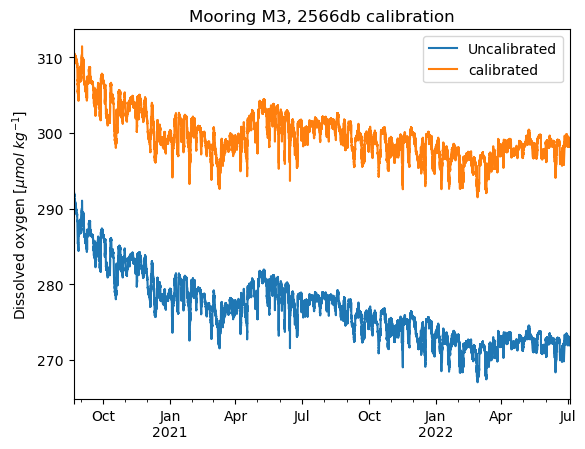

In [28]:
coeffs = np.polyfit([0, len(optode_oxy_corr2)],[G_t1, G_t2], 1)
G_t = (np.arange(len(optode_oxy_corr2.values))*coeffs[0] + coeffs[1])

optode_oxy_calibrated = optode_oxy_corr2 * G_t

optode_oxy_corr.plot(label = 'Uncalibrated')
optode_oxy_calibrated.plot(label = 'calibrated')

plt.ylabel('Dissolved oxygen $[\mu mol \ kg^{-1}]$')
plt.legend()
plt.title('Mooring ' + df_sn.station.values[0] + ', ' + str(int(np.round(mc_tmp.PRES.median()))) + 'db calibration')

# 7. Load available BGC-ARGO-DO profiles

These Argo profiles were matched to the optode using temperature (+-0.005), salinity (+-0.005), and pressure (+-100 db) thresholds and are within a 100km radius of the mooring site. See https://github.com/ellenrpark/bgcargo_floatmatchup for the code used to find and download BGC-ARGO profiles that match with the OSNAP mooring sites within user-specified constraints.

c:\Users\bikbe\anaconda3\envs\bgc_matchups\Lib\site-packages\matplotlib\axes\_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\bikbe\anaconda3\envs\bgc_matchups\Lib\site-packages\matplotlib\axes\_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
c:\Users\bikbe\anaconda3\envs\bgc_matchups\Lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\bikbe\anaconda3\envs\bgc_matchups\Lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


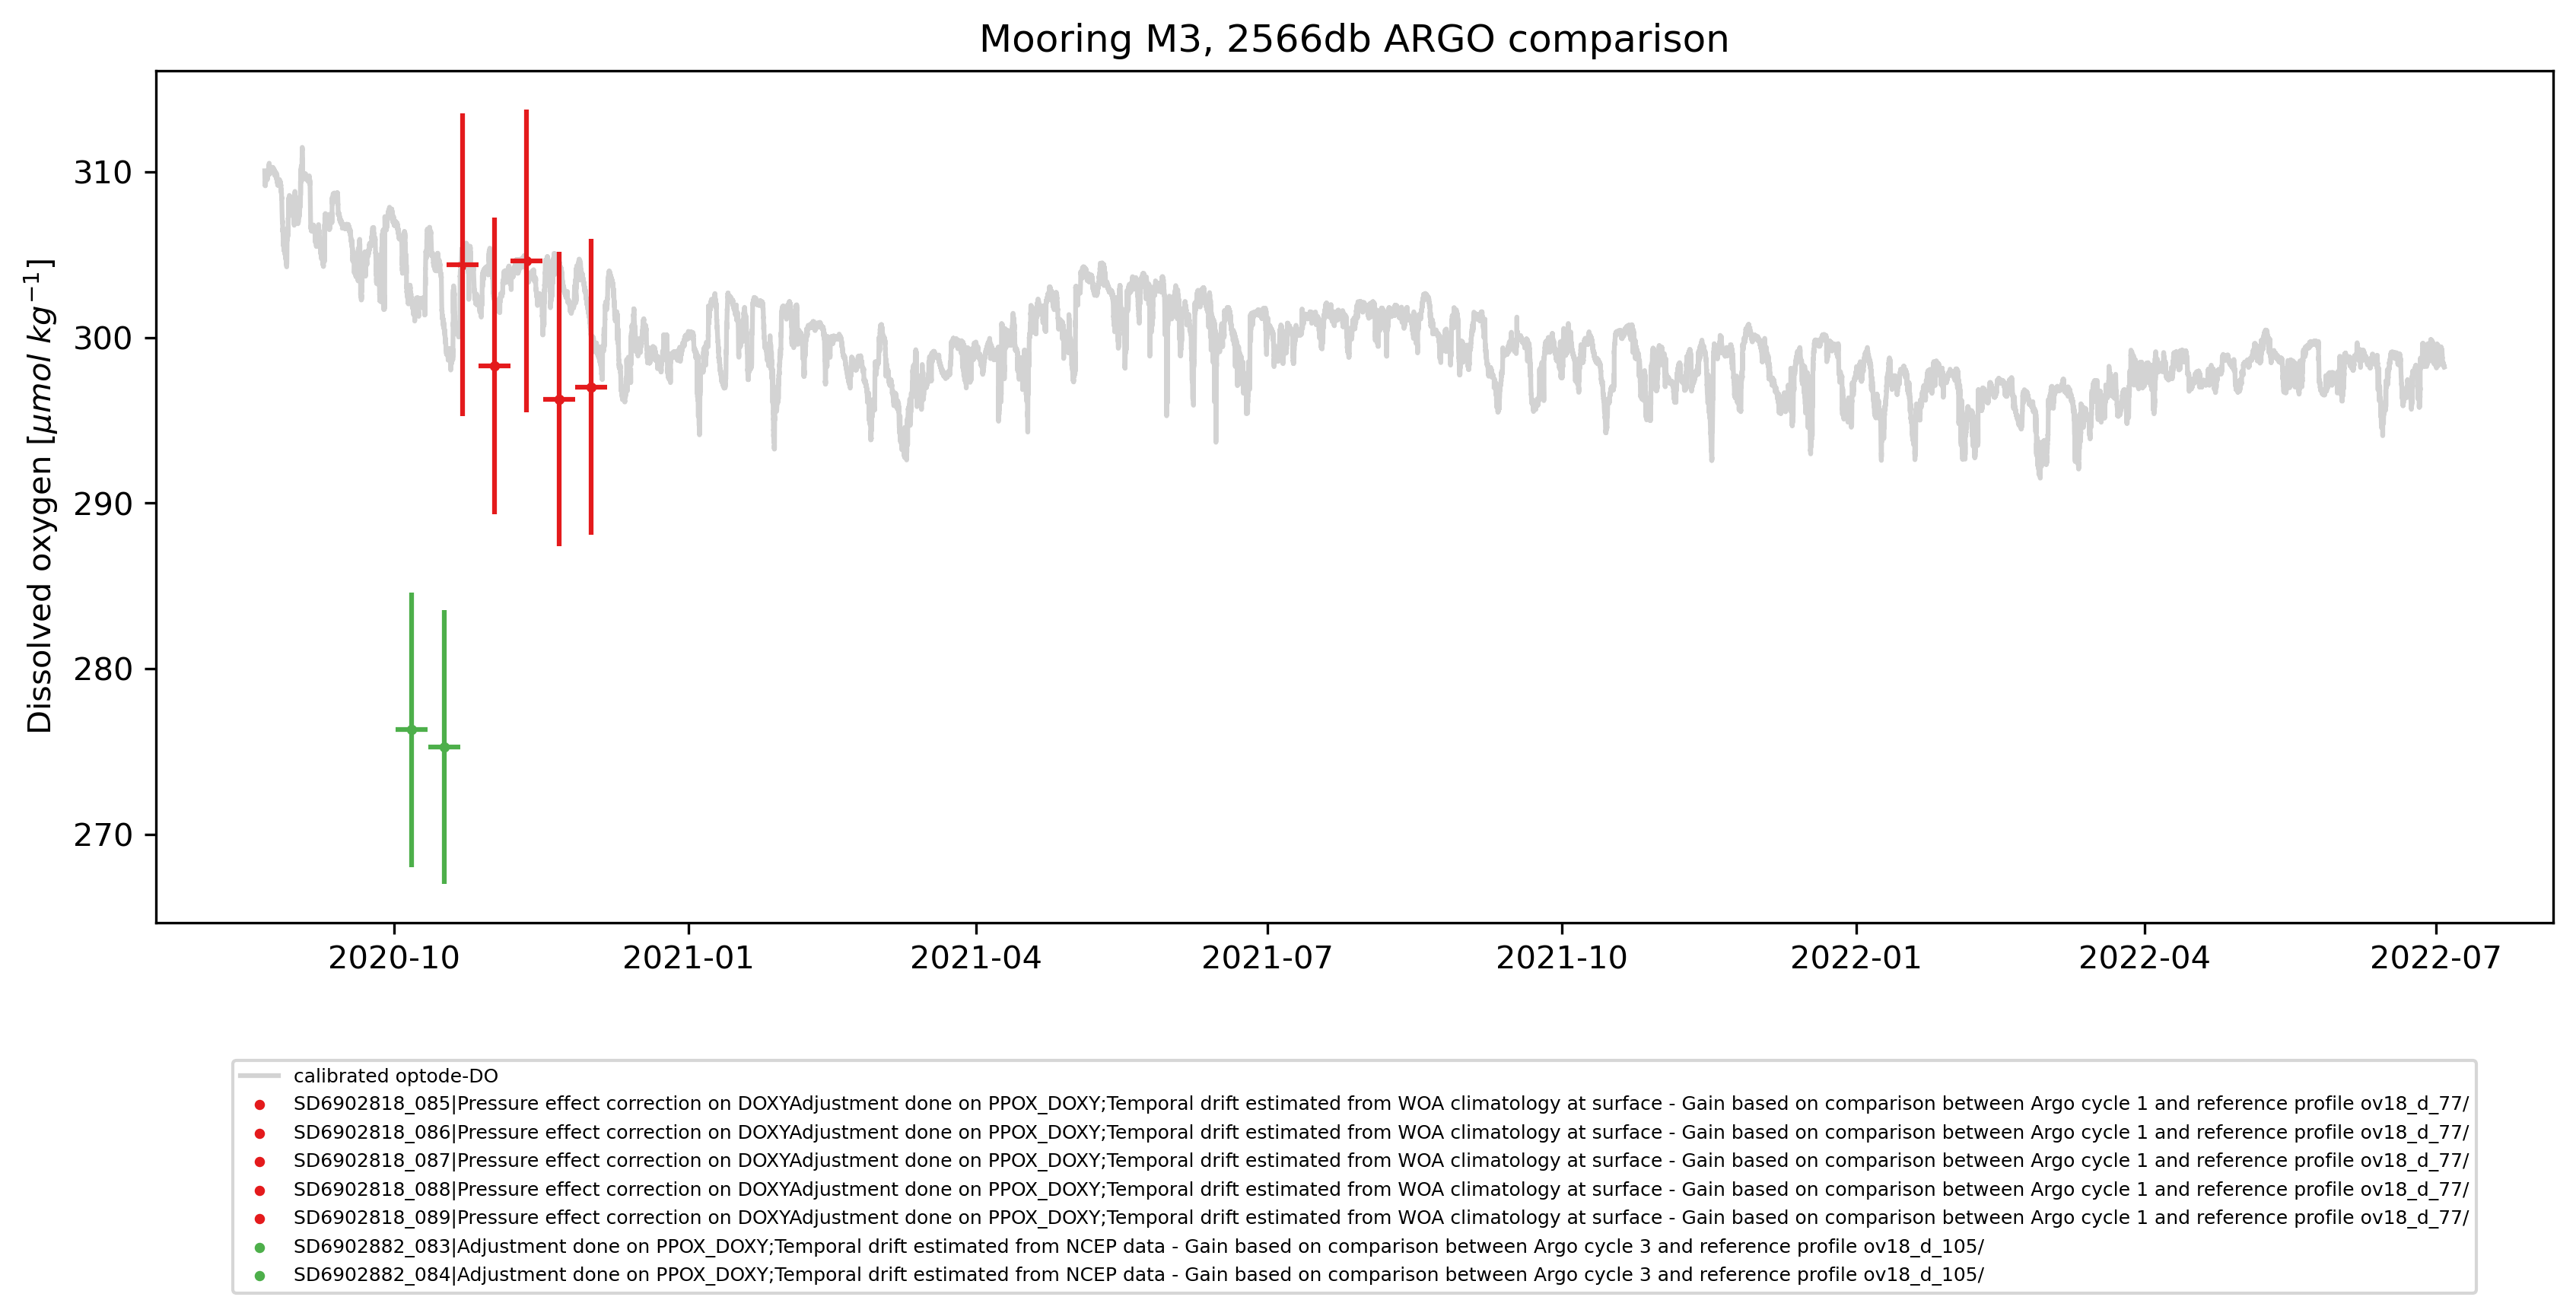

In [29]:
df = pd.read_csv(os.path.join(os.path.join('Files',str(serial_num),'204380_M3_2557dbar.csv')))


df.index = pd.to_datetime(df.date, format = '%Y%m%d%H%M%S')
argo_SD = []
for i in np.arange(len(df)):
        argo_SD.append(os.path.basename(df.file.iloc[i])[2:].split("_")[0])
viridis = mpl.colormaps['Set1'].resampled(len(np.unique(argo_SD))+2)

asal = gsw.SA_from_SP(df.PSAL,df.PRES,df.longitude, df.latitude)
df['PTEMP'] = gsw.pt0_from_t(asal,df.TEMP,df.PRES)


plt.figure(figsize = ((12,6)), dpi = 300)
ax = plt.subplot(111)             

#optode_oxy_calibrated.plot(label = 'calibrated')
plt.plot(optode_oxy_calibrated.index,optode_oxy_calibrated, color = 'lightgray', label = 'calibrated optode-DO')

for i in range(df.shape[0]):

    if type(df.iloc[i].DOXY_COMMENT) != float:
        
        if df.iloc[i].DOXY_MODE in ['D']: #'A', # Delayed (QC) mode only



            color = viridis(np.argwhere(np.unique(argo_SD) == os.path.basename(df.file.iloc[i])[2:].split("_")[0])[0][0])
            
            # if df.iloc[i].DOXY_MODE == 'A':
            #      marker = '^'
            # else:
            #      marker = 'o'

            if np.isnan(df.DOXY.iloc[i]) == False:
            
                
                h = plt.scatter(pd.to_datetime(df.iloc[i].date_format),df.iloc[i].DOXY,s = 5,# s = 40, 
                                color = color,# vmin =0, vmax = 100, cmap ='tab20c', [2:].split(".")[0]
                                label =  os.path.basename(df.file.iloc[i]).split('.')[0] +  '|' + df.iloc[i].DOXY_COMMENT[:200]) # + #df.iloc[i].DOXY_MODE

                
            plt.errorbar(pd.to_datetime(df.iloc[i].date_format), df.iloc[i].DOXY, 
                            yerr = df.iloc[i].DOXY_ERROR,  xerr = pd.Timedelta('5d'),  color = color, zorder = 5) #) 

plt.ylabel('Dissolved oxygen $[\mu mol \ kg^{-1}]$')

plt.title('Mooring ' + df_sn.station.values[0] + ', ' + str(int(np.round(mc_tmp.PRES.median()))) + 'db ' + 'ARGO comparison')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize = 6)
plt.tight_layout()

# 8.  Save calibrated optode-DO in FAIR format

In [30]:
ds = xr.Dataset(
data_vars=dict(
    temp=(["time"], mc_tmp.TEMP.values,{'full name':'Microcat in situ temperature','units':'deg C'}),
    ptemp=(["time"], mc_tmp.PTEMP.values,{'full name':'Microcat potential temperature','units':'deg C'}),
    psal=(["time"], mc_tmp.PSAL.values,{'full name':'Microcat practical salinity','units':'PSU'}),
    pres=(["time"], mc_tmp.PRES.values,{'full name':'Microcat pressure','units':'dbar'}),
    DO=(["time"], mc_tmp.DOXY.values,{'full name':'Optode uncalibrated dissolved oxygen','units':'micro moles per kilogram'}),
    DO_calibrated=(["time"], optode_oxy_calibrated,{'full name':'Optode calibrated dissolved oxygen','units':'micro moles per kilogram'})

),
coords=dict(

    time=mc_tmp.index.values,
    
),
attrs=dict(Serial_number = str(serial_num), Make = 'Aanderaa 4330 optode integrated with RBR logger', Mooring_id=df_sn.station.values[0], 
           Nominal_depth = df_sn.nominal_depth.values[0], Median_pressure = mc_tmp.PRES.median(), 
           latitude = df_sn.latitude.values[0],
            longitude = df_sn.longitude.values[0], Corrected_for_reversible_drift = 'No', P_corr_factor = cf[np.argmin(diff_std)], 
            G_t1 = G_t1, G_t2 = G_t2, Processing_description = 'See Miller et al. for descriptions of P_corr_factor, G_t1, G_t2' )

)

ds.to_netcdf(os.path.join('Files',str(serial_num),str(serial_num)+'_calibrated_DO.nc'))
ds

<xarray.Dataset>
Dimensions:        (time: 65376)
Coordinates:
  * time           (time) datetime64[ns] 2020-08-21T15:00:00 ... 2022-07-03T1...
Data variables:
    temp           (time) float32 1.332 1.331 1.33 1.33 ... 1.703 1.703 1.701
    ptemp          (time) float64 1.158 1.157 1.156 1.156 ... 1.521 1.521 1.52
    psal           (time) float32 34.87 34.87 34.87 34.87 ... 34.88 34.88 34.88
    pres           (time) float32 2.559e+03 2.559e+03 ... 2.565e+03 2.565e+03
    DO             (time) float64 272.4 272.3 272.1 272.0 ... 251.9 251.9 251.9
    DO_calibrated  (time) float64 310.1 309.9 309.8 309.7 ... 298.2 298.2 298.2
Attributes:
    Serial_number:                   204380
    Make:                            Aanderaa 4330 optode integrated with RBR...
    Mooring_id:                      M3
    Nominal_depth:                   2557.0
    Median_pressure:                 2565.558
    latitude:                        59.819
    longitude:                       -40.275
    Corrected_for_reversible_drift:  No
    P_corr_factor:                   0.030999999999999986
    G_t1:                            1.069655444249485
    G_t2:                            1.0965324613211442
    Processing_description:          See Miller et al. for descriptions of P_...